# Introduction to Trancriptomics using Python3 

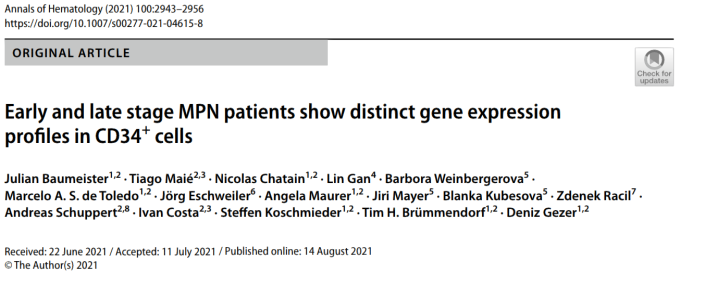

![](img/Header.png)
*By: Msc. James S. Nagai, Msc. Tiago Maié, Steffen Koschmieder and Ivan G. Costa*

In this course, we will perform gene expression analysis with data from CD34+ cells from MPN patients presented in the above study ([paper](https://link.springer.com/article/10.1007/s00277-021-04615-8)). For this, we will consider previously normalized gene expression data and will perform down-stream analysis such as principal component analysis, clustering, identification of differentially expressed genes and gene ontology analysis. The course is organized into the following sections:
    
1. [HandsOn1-Analysing RNA expression data](#section_1) Here we will perform a dimension reduction using different embbedding algorithms to check the variability presented by our dataset.

2. [HandsOn2-Differential Gene Expression](#section_2) Here we will perform a differential gene expression analysis to identify genes have increase or decrease in expression in MPN samples. 

3. [HandsOn3- Complex Differential Gene Expression](#section_3)Here we will perform a differential gene expression contrasting distinct MPN entities. 

 <a id="section_1"></a>
## 1. Analysing RNA Expression Samples and its Organization

### 1.1.1 Importing the Libraries
Here we need to include all the libraries needed in the analysis process. Note that, you can easily find the documentation and explore each library in depth as you want.

* **Data Science and Mathematics**
   [scipy](https://scipy.org/)
   [numpy](https://numpy.org/)
   [pandas](https://pandas.pydata.org/)
   [sklearn](https://scikit-learn.org/stable/)

* **Visualization**
   [matplotlib](https://matplotlib.org/)
   [seaborn](https://seaborn.pydata.org/)
   
* **RNA Data Organization and DE analysis**
   [anndata](https://anndata.readthedocs.io/en/latest/)
   [diffxpy](https://diffxpy.readthedocs.io/en/latest/)

* **Gene Enrichment Analysis**
   [gprofiler](https://biit.cs.ut.ee/gprofiler/gost)

In [ ]:
from scipy.cluster.hierarchy import average, fcluster
from scipy.spatial.distance import pdist,squareform
from scipy import cluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import diffxpy.api as de
import anndata
from gprofiler import GProfiler
sns.set_style("whitegrid")

### 1.2 Data Aquisition and Pre-processing

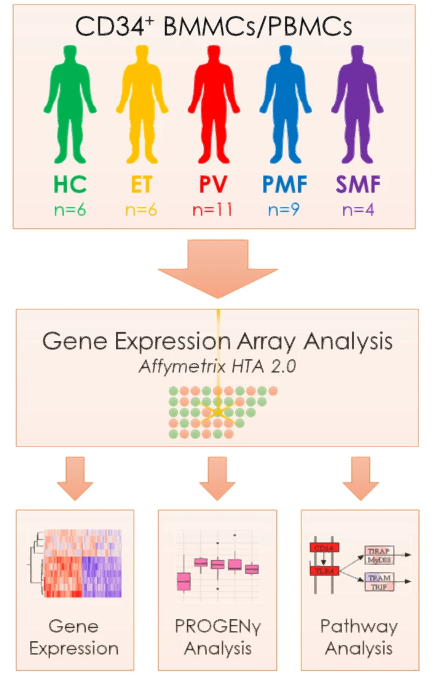

First, we will load a pre-processed gene expression table from our 36 patient/donor samples (gene_exp.csv). Additionally, we will load a metadata table containing patient clinical information including disease entity (HC,ET,PV,PMF and SMF); age, sex, type of treatment and so on. The number of samples per disease entity is shown above. 

In [ ]:
data = anndata.read_h5ad("./data/cd34.h5ad")

Now, we can check the distribuition of the gene expression in each collected sample.

In [ ]:
plt.figure(figsize=(15,8),dpi=600)
data.to_df().T.boxplot()
l=plt.xticks(rotation=45)

We we will sort the clinical data to follow the same organization of samples as in the gene expression file. 


In [ ]:
# Using pandas to plot small things like the Diagnosis distribuition
data.obs.value_counts('Diagnosis').plot(kind='bar')

![](img/anndata.png)

### 1.4 Dimension Reduction

A common first task is to perform dimension reduction and inspect potential groups of (MPN) samples. Here, we will consider the linear dimension reduction method PCA, which was discussed in our lecture.

<center><img src="img/Pca.png" alt="pca" /></center>

**PCA documentation:** https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [ ]:
# Here, we will create a PCA object using as input the number of desired components
PCAembb = PCA(n_components = 3) 
# Now, we can use our gene expression matrix to compute our PCA
X_transformed = PCAembb.fit_transform(data.X)

Next, we will plot the results using a scatter plot. The package seaborn provides nice aesthetics for this. 

**seaborn scatter plot:** https://seaborn.pydata.org/generated/seaborn.scatterplot.html

In [ ]:
# Now that we have our PCA done, we can try to visualize our PCA in a plot 
label1 = 'PCA_1' # Here we will define labels respective to our PCs
label2 = 'PCA_2'
# Next, we can store our PCs in the obs, can you remember what we have within obs in our AnnData object?
data.obs[label1] = X_transformed[:,0]
data.obs[label2] = X_transformed[:,1]
plt.figure(figsize=(6,6))
sns.scatterplot(x=label1,y=label2,
                c=data.obs['Diagnosis'].cat.codes, # getting the codes instead the Diagnosis label
                style=data.obs['Diagnosis'],
                data=data.obs,
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 1.5 Adding the text over the samples

We can further enrich the previous plot by adding text over the dots (name of samples). 

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=label1,y=label2,
                c=data.obs['Diagnosis'].cat.codes,
                style=data.obs['Diagnosis'],
                data=data.obs,
                legend=True)
# Here we will add a label to each point from the PCA
for i in range(data.obs.shape[0]):
    plt.text(x=data.obs[label1][i]+0.3,
         y=data.obs[label2][i]+0.3,
         s=data.obs.Diagnosis[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### 1.6 Variance explained by each component

In [ ]:
PCAembb.explained_variance_ratio_

### 1.7 Gene Importance per PC

In [ ]:
PCAembb.components_.T

### 1.8 Exercices

#### 1.8.1 Color the PCA using the clinical metadata Sex

#### 1.8.2 Change the size of each dot using the Allele Burden clinical metadata

#### 1.8.3 Check if driver mutations groups together in the PCA

#### 1.8.4 Can you try to plot PC 2 vs. PC3 ? 

<a id="section_2"></a>
## 2. Differential Gene Expression Simple Case: Healthy vs Diseased

In this section, we will perform differential expression analysis. First, we will explore genes with change in expression in healthy and diseased (MPNs). 

### 2.1 Defining our comparisons

As an initial step, we need to define our comparison. We will create a new variable, "condition", for this. 

In [ ]:
# Assing to condition True if Diagnosis is HC False otherwise
data.obs['condition'] = data.obs['Diagnosis']!='HC' 
# Change bool to int
data.obs['condition'] = data.obs['condition'].astype('int')

In [ ]:
data.obs.head()

### 2.2 Performing differential analysis with a t-test 

Next, we perform a t-test to find genes with increased (or decreased) expression when comparing these two groups of donors. 

In [ ]:
test = de.test.t_test(
    data=data,           # AnnData
    grouping="condition" # .obs column used to do the analysis
)

#### 2.2.1 Show the genes in a volcano plot

We can do an initial check of the results by using a volcano plot. This plot shows the change in expression (FC) in the x-axis vs. the significance of this change (p-value) in the y-axis. Positive FC indicates genes that have higher expression in the disease samples rather than in the control samples. Negative FC indicates genes that have a higher expression in the control samples, rather than in the disease samples.

In [ ]:
plt.figure(figsize=(8,8))
test.plot_volcano(corrected_pval=True, min_fc=1.18, alpha=0.05, size=20) 
plt.show()

### 2.3 Exploring the results

To further our analysis, we will get the test output table with the results for the differential analysis.  We will look for down- or up-regulated genes in the disease. 

In [ ]:
result = test.summary() # Getting the test result in a pandas df
result.head()

In [ ]:
result.tail()

Next we will select the DE genes such that the corrected p-values and the change in expression obey some thresholds. In this case we want genes that appear to be significantly expressed (qvalue < 0.05) and with a high change in expression values (|log2fc| > 0.5).

In [ ]:
highlight = np.bitwise_and(result['qval'] <= 0.05,np.abs(result['log2fc']) > 0.5)

To see how those DE-genes are expressed in our dataset, we will make a heatmap using seaborn.

In [ ]:
reshighlights = test.summary().loc[highlight,]

In [ ]:
reshighlights = reshighlights.sort_values(by='log2fc',ascending=False)

Showing the most under- and over-expressed genes in our comparisons.

In [ ]:
genes = [reshighlights['gene'].iloc[-1],reshighlights['gene'].iloc[1]]

In [ ]:
intgenes=data[:,genes].to_df()
intgenes['Diagnosis'] = data.obs['Diagnosis']


In [ ]:
intgenes.head()

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
intgenes.boxplot(by='Diagnosis',ax=ax)
plt.show()

Note that, initially, we will use the **euclidean distance** with the **average clustering** method

In [ ]:
sns.clustermap(data[:, reshighlights['gene']].to_df().T,
               metric='euclidean',   # Distance
               method='average',     # Clustering method
               cmap=plt.cm.RdYlBu_r, # Color Pallete
               z_score=0             # Normalization axis 0 rows 1 columns
               )

### 2.4 Gene Ontology enrichment analysis

We will now check if DE up-regulated genes are associated with particular gene ontology terms using a Fischer's exact test, as implemented by g:profiler. 

In [ ]:
gp = GProfiler(return_dataframe=True) # creating a gprofiler object
up_regulated=reshighlights['gene'][reshighlights['log2fc']>0].tolist()
enrich = gp.profile(organism='hsapiens',
            query=up_regulated,
            sources=["GO:MF","GO:CC","GO:BP"]) # querying g:profiler, providing up-regulated genes as input

# we can check the results
enrich.head()

 We can now plot the results as a bar plot. The siginificance is shown as a -log(10) of the p-value, where higher values indicate a higher significance. 

In [ ]:
enrich['NES'] = -np.log10(enrich['p_value'])
enrich.sort_index(axis=0,level='NES',inplace=True)
sns.barplot(x='NES',y='name',data=enrich.iloc[1:20,],color='red')  

### 2.5 Exercices

#### 2.5.1 Change the metric and method parameters in the clustermap function. For example, you can try using a distinct distance metric or a distinct clustering method. 



#### 2.5.2 Perform the GO analysis on down-regulated genes upon disease.  


<a id="section_3"></a>
# 3. Differential Gene Expression: Healthy vs individual MPN disease entities 

We can now repeat the analysis from section 2, but now focusing on the comparison of HC vs. MPN entities (PV, ET, PMF and SMF). As the code here is similar as in section 2, we will not describe everything in detail. 

In [ ]:
test = de.test.pairwise(
    data=data,            # AnnData
    grouping="Diagnosis", # Diagnosis column
    test="t_test",        # Type of the test
    lazy=False,           # Computing mode
    noise_model=None)

In [ ]:
pmf = test.summary_pairs(groups0=['HC'],groups1=['PMF']) #results of the comparison HC vs. PMF

In [ ]:
pmfhighlight = np.bitwise_and(pmf['qval'] <= 0.05, np.abs(pmf['log2fc']) > 0.25)

In [ ]:
plt.figure(figsize=(8,8))
test.plot_volcano(corrected_pval=True, min_fc=1.18, alpha=0.05, size=20) 
plt.show()

In [ ]:
pmfres = pmf.loc[pmfhighlight,]

In [ ]:
pmfres.head()

In [ ]:
selsamples = data.obs['Diagnosis'].isin(['HC','PMF'])

In [ ]:
sns.clustermap(data[selsamples, pmfres['gene']].to_df().T,
               metric='euclidean',
               method='average',
               cmap=plt.cm.RdYlBu_r,
               z_score=0)

In [ ]:
pmfres = pmfres.sort_values(axis=0,by='log2fc',ascending=False)

In [ ]:
pmfres

In [ ]:
gp = GProfiler(return_dataframe=True)
enrich = gp.profile(organism='hsapiens',
            query=pmfres['gene'][0:100].to_list(),
            sources=["GO:MF","GO:CC","GO:BP"])
enrich['NES'] = -np.log10(enrich['p_value'])
enrich.sort_index(axis=0,level='NES',inplace=True)
sns.barplot(x='NES',y='name',data=enrich.iloc[1:20,],color='red')  

### 3.1 Do the remaining comparisons presented by the paper

#### 3.1.1 Perform DE, clustering and GO analysis for other entity comparirsons (HC vs. ET, HC vs. PV, ...). 